# Parameter Estimation - Stochastic SIR model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import gaussian_kde
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
low_beta = 0.01 
high_beta = 1. 
low_gamma = 0.

def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for rate parameters: 
    beta_samples = np.random.uniform(low=low_beta, high=high_beta, size=batch_size)
    gamma_samples = np.random.uniform(low=low_gamma, high=beta_samples)
    p_samples = np.c_[beta_samples, gamma_samples]
    return p_samples.astype(np.float32)

N = 1000   # population size
u0 = [N-1,1,0]   # initial state  
iota = 0.5 
dt = 0.1   # time step
n_dt = 500   # number of simulation time steps
t_end = n_dt * dt
n_obs = 21   # number of observations
time_points = np.linspace(0, t_end, n_obs)
missing_max = 15

def simulate_sir_single(beta, gamma):
    """Simulates a single SIR process."""
    
    def sir_equation(u):
        """Implements the stochastic SIR equations."""
        S, I, R = u
        lambd = beta *(I+iota)/N
        ifrac = 1.0 - np.exp(-lambd*dt)
        rfrac = 1.0 - np.exp(-gamma*dt)
        infection = np.random.binomial(S, ifrac)
        recovery = np.random.binomial(I, rfrac)
        return [S-infection, I+infection-recovery, R+recovery]
    
    S = np.zeros(n_obs)
    I = np.zeros(n_obs)
    R = np.zeros(n_obs)
    u = u0
    S[0], I[0], R[0] = u
    
    for j in range(1, n_dt+1):
        u = sir_equation(u)
        if j % 25 == 0:
            i = j//25
            S[i], I[i], R[i] = u
        
    return np.array([S, I, R]).T/N

def batch_simulator(prior_samples, n_obs):  
    """
    Simulate multiple SIR model data sets with missing values and time labels (normalized)
    """    
    n_sim = prior_samples.shape[0]   # batch size
    n_missing = np.random.randint(0, missing_max + 1)
    n_present = n_obs - n_missing
    sim_data = np.empty((n_sim, n_present, 4), dtype=np.float32)  # 1 batch consisting of n_sim datasets, each with n_present observations
    
    for m in range(n_sim):
        missing_indices = random.sample(range(n_obs), n_missing)
        present_indices = np.setdiff1d(range(n_obs), missing_indices)
        present_timepoints = time_points[present_indices]
        sim_data[m, :, 0:3] = simulate_sir_single(prior_samples[m, 0], prior_samples[m, 1])[present_indices]
        sim_data[m, :, 3] = present_timepoints / t_end

    return sim_data

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [4]:
# Time labels
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./SIR_stoch_timelabels_5ACB_[64,64,64]_LSTM(128)_ckpts', skip_checks=True)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./SIR_stoch_timelabels_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300


## Generate test data

In [5]:
# Load test data
param_priors = np.array([[0.72, 0.41], [0.45, 0.23], [0.26, 0.07], [0.87, 0.05], [0.15, 0.14]])  
y_datas = np.load("x_datas.npy")

In [6]:
# Select data to be shown
param_priors = param_priors[[0,3,2]]
y_datas = y_datas[[0,3,2]]

In [7]:
# Encode using Time labels
x_datas = []

for y_data in y_datas:
    bin_ind = y_data[:,3]
    present_indices = np.where(bin_ind == 1.)[0]
    x_data = np.empty((len(present_indices), 4), dtype=np.float32)
    x_data[:, 0:3] = y_data[present_indices, 0:3]
    x_data[:, 3] = time_points[present_indices]/t_end
    x_datas.append(x_data)

## Computational faithfulness

In [8]:
# Sample from BayesFlow
n_post_samples = 7500 
param_samples = []

for x_data in x_datas:
    param_sample = amortizer.sample(np.array([x_data]), n_post_samples)
    param_samples.append(param_sample)

param_samples = np.asarray(param_samples)

In [9]:
# Results from pyABC analysis
pyabc_samples = []
pyabc_weights = []

for i in [0,3,2]:
    s = np.load(("./pyabc_history/pyabc_samples_{}.npy".format(i)))
    w = np.load(("./pyabc_history/pyabc_weights_{}.npy".format(i)))
    pyabc_samples.append(s)
    pyabc_weights.append(w)

## Posterior plot

In [10]:
cmap = "viridis"

def plot_posterior(ax, param_samples, pyabc_samples, pyabc_weights, data_id):
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.1)
    
    # Level sets from pyABC samples 
    sns.kdeplot(x=pyabc_samples[:,0], y=pyabc_samples[:,1], weights=pyabc_weights, levels=6, cmap=cmap, ax=ax)

    ax.set_xlabel(r'Parameter $\beta$')
    ax.set_ylabel(r'Parameter $\gamma$')
    ax.set_title('Data set {}'.format(data_id))

## Posterior predictive check

In [11]:
time_line = np.linspace(0, t_end, n_dt+1) 

def simulate_sir_single_full(beta, gamma):
    """Simulates a single SIR process."""
    
    def sir_equation(u):
        """Implements the stochastic SIR equations."""
        S, I, R = u
        lambd = beta *(I+iota)/N
        ifrac = 1.0 - np.exp(-lambd*dt)
        rfrac = 1.0 - np.exp(-gamma*dt)
        infection = np.random.binomial(S, ifrac)
        recovery = np.random.binomial(I, rfrac)
        return [S-infection, I+infection-recovery, R+recovery]
    
    S = np.zeros(n_dt+1)
    I = np.zeros(n_dt+1)
    R = np.zeros(n_dt+1)
    u = u0
    S[0], I[0], R[0] = u
    
    for j in range(1, n_dt+1):
        u = sir_equation(u)
        S[j], I[j], R[j] = u
        
    return np.array([S, I, R]).T/N

In [12]:
def plot_predictive_check(ax, param_prior, x_data, param_samples, n_sim=1000):
    
    time_avail = time_points[x_data[:,3]==1]
    x_avail = x_data[x_data[:,3]==1, 0:3]
        
    traj_sim = np.empty((n_sim, n_dt+1, 3))

    for k in range(n_sim):
        traj_sim[k] = simulate_sir_single_full(param_samples[k,0], param_samples[k,1])
        
    traj_mean = np.mean(traj_sim, axis=0)
    traj_quantiles = np.quantile(traj_sim, [0.05, 0.95], axis=0)
    
    ax.plot(time_line, traj_mean[:,0], color='deepskyblue', label='Simulated mean $S$')
    ax.fill_between(time_line, traj_quantiles[0,:,0], traj_quantiles[1,:,0], color='deepskyblue', alpha=.25)
    ax.plot(time_line, traj_mean[:,1], color='orange', label='Simulated mean $I$')
    ax.fill_between(time_line, traj_quantiles[0,:,1], traj_quantiles[1,:,1], color='orange', alpha=.25)
    ax.plot(time_line, traj_mean[:,2], color='limegreen', label='Simulated mean $R$')
    ax.fill_between(time_line, traj_quantiles[0,:,2], traj_quantiles[1,:,2], color='limegreen', alpha=.25)
    
    ax.plot(time_avail, x_avail[:,0], 'o', color='tab:blue', markersize=4.25, label='Available data $S$')
    ax.plot(time_avail, x_avail[:,1], 'o', color='tab:orange', markersize=4.25, label='Available data $I$')
    ax.plot(time_avail, x_avail[:,2], 'o', color='tab:green', markersize=4.25, label='Available data $R$')
    
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")

## Combined plot

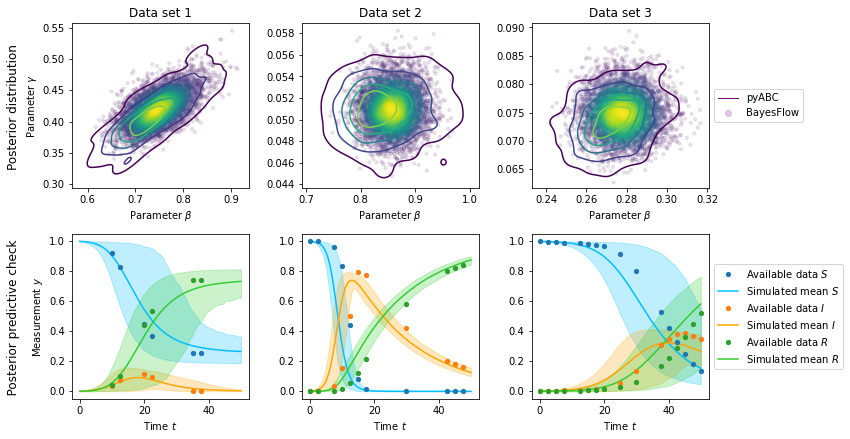

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6.2))

for j in range(len(x_datas)):
    
    # Posterior plot
    ax = axes[0,j]
    plot_posterior(ax, param_samples[j], pyabc_samples[j], pyabc_weights[j], j+1)
    if j == 2:
        legend_elements = [
            Line2D([0], [0], color="purple", lw=1, label="pyABC"),
            Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
        ]
        ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))
    if j > 0:
        ax.set_ylabel(None) 
    
    # Predictive check
    ax = axes[1,j]
    plot_predictive_check(ax, param_priors[j], y_datas[j], param_samples[j])      
    if j == 2:
        handles, labels = ax.get_legend_handles_labels()
        order = [3,0,4,1,5,2]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1, 0.5))
    if j > 0:
        ax.set_ylabel(None)

fig.supylabel("   Posterior predictive check                  Posterior distribution   ")
fig.tight_layout()

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/SIR_stoch_time.{fmt}", dpi=300, bbox_inches='tight')